In [ ]:
import pandas as pd
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.io import read_image
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

# Dataset

In [60]:
class Speleothem(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_labels = self.img_labels.sort_values(by=['file'])
        self.img_labels = self.img_labels[self.img_labels["resolution"] > 1000]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.count_max = int(self.img_labels["count"].max())
        self.count_min = int(self.img_labels["count"].min())
        self.num_classes = self.count_max - self.count_min + 1

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_dir + f"classify_{self.img_labels.iloc[idx, 2]}/{self.img_labels.iloc[idx, 0]}.png"
        
        image = Image.open(img_path)

        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, int(label) - self.count_min

In [61]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
speleothem = Speleothem("../image/dbe/database.csv", "../image/dbe/", transform=preprocess)
len(speleothem)

61

In [62]:
from sklearn.model_selection import train_test_split
train_size = int(0.8 * len(speleothem))
test_size = len(speleothem) - train_size
train_dataset, test_dataset = random_split(speleothem, [train_size, test_size])
# train_dataset = torch.utils.data.Subset(speleothem, range(train_size))
# test_dataset = torch.utils.data.Subset(speleothem, range(train_size, train_size + test_size))

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

tensor(12)


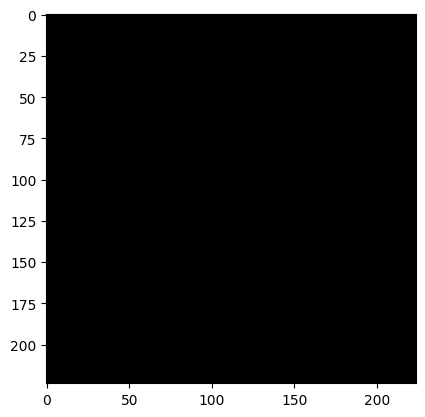

In [63]:
train_features, train_labels = next(iter(train_dataloader))
plt.imshow(train_features[0].int().permute(1, 2, 0))
print(train_labels[0])

# Model

In [64]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"
print(f"Using {device} device")

Using cuda device


In [65]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.fc = nn.Linear(512, speleothem.num_classes+1)
model.to(device)
print(model)

Using cache found in /home/diler/.cache/torch/hub/pytorch_vision_v0.10.0
/home/diler/.cache/pypoetry/virtualenvs/speleothem-D0j3gjp0-py3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/diler/.cache/pypoetry/virtualenvs/speleothem-D0j3gjp0-py3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
model34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model34.fc = nn.Linear(2048, speleothem.num_classes+1)
model34.to(device)
print(model34)

Using cache found in /home/diler/.cache/torch/hub/pytorch_vision_v0.10.0
/home/diler/.cache/pypoetry/virtualenvs/speleothem-D0j3gjp0-py3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/diler/.cache/pypoetry/virtualenvs/speleothem-D0j3gjp0-py3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Train

In [66]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [67]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss = loss.item()
            print(f"loss: {loss:>7f}")

In [68]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [70]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
loss: 0.034996
Test Error: 
 Accuracy: 7.7%, Avg loss: 3.032898 

Epoch 2
loss: 0.097791
Test Error: 
 Accuracy: 7.7%, Avg loss: 2.729473 

Epoch 3
loss: 0.044612
Test Error: 
 Accuracy: 0.0%, Avg loss: 2.904920 

Epoch 4
loss: 0.285334
Test Error: 
 Accuracy: 7.7%, Avg loss: 3.014120 

Epoch 5
loss: 0.050716
Test Error: 
 Accuracy: 7.7%, Avg loss: 2.961800 

Epoch 6
loss: 0.030121
Test Error: 
 Accuracy: 7.7%, Avg loss: 2.972197 

Epoch 7
loss: 0.047438
Test Error: 
 Accuracy: 7.7%, Avg loss: 3.059641 

Epoch 8
loss: 0.063454
Test Error: 
 Accuracy: 0.0%, Avg loss: 3.104024 

Epoch 9
loss: 0.195363
Test Error: 
 Accuracy: 7.7%, Avg loss: 3.143555 

Epoch 10
loss: 0.123271
Test Error: 
 Accuracy: 7.7%, Avg loss: 3.183042 

Epoch 11
loss: 0.292009
Test Error: 
 Accuracy: 7.7%, Avg loss: 2.790937 

Epoch 12
loss: 0.039373
Test Error: 
 Accuracy: 0.0%, Avg loss: 2.821544 

Epoch 13
loss: 0.042332
Test Error: 
 Accuracy: 7.7%, Avg loss: 2.780886 

Epoch 14
loss: 0.087599
Test Error

# Test

In [ ]:
model.eval()

predicted = []
true = []
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        predicted.extend(pred.argmax(1).tolist())
        true.extend(y.tolist())


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

confusion_matrix(true, predicted)
ConfusionMatrixDisplay(confusion_matrix(true, predicted)).plot()

In [ ]:
accuracy_score(true, predicted)